## Import Libraries

In [18]:
# 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf


## Step 2. plot_rolling_statistics() 

In [4]:

# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

## Step 3. augmented_dickey_fuller_test() 구현

In [5]:

# 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 함수
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:
# matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 13, 6    

## Step 4. stock_stationarity() 구현

In [7]:
def stock_stationarity(stock_id,  period = 30):
    start = "2014-09-17"
    end = "2024-02-14"
    df = yf.download(stock_id, start, end, auto_adjust=True)

    # Close만 사용
    ts = df['Close']

    # 결측치 처리
    ts = ts.interpolate(method='time')

    # 로그 변환
    ts_log = np.log(ts)
    print('\033[31m'+'\033[1m' + "로그 변환된 그래프 :" + '\033[0m') 
    plt.plot(ts_log)
    plt.show()

    # 정성적 그래프 분석
    print()
    print('\033[31m'+'\033[1m' + "정성적 그래프 분석 :" + '\033[0m')    
    plot_rolling_statistics(ts_log, window=12)

    #정량적 Augmented Dicky-Fuller Test
    print()
    print('\033[31m'+'\033[1m' + "정량적 Augmented Dicky-Fuller Test :" + '\033[0m')    
    augmented_dickey_fuller_test(ts_log)
    
    #시계열 분해 (Time Series Decomposition)
    print()  
    print('\033[31m'+'\033[1m' + "시계열 분해 (Time Series Decomposition) :" + '\033[0m')    
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Residual 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)
    
    
    # 학습과 테스트 데이터셋을 9:1로 분리
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

    print()
    print('\033[31m'+'\033[1m' + "학습과 테스트 데이터셋 :" + '\033[0m')
    plt.figure(figsize=(13,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    plt.show()
    
    # ACF, PACF 그려보기 -> p,q 구하기
    print()
    print('\033[31m'+'\033[1m' + "ACF : Autocorrelation 그래프 :" + '\033[0m')    
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plt.show()
    
    print()
    print('\033[31m'+'\033[1m' + "PACF : Partial Autocorrelation 그래프 :" + '\033[0m')     
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()
    
    
    # 차분 안정성 확인 -> d 구하기
    # 1차 차분 구하기
    print()
    print('\033[31m'+'\033[1m' + "1차 차분 구하기 :" + '\033[0m')     
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')
    augmented_dickey_fuller_test(diff_1)

    # 혹시 필요한 경우 2차 차분 구하기
    print()
    print('\033[31m'+'\033[1m' + "2차 차분 구하기 :" + '\033[0m')    
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')
    augmented_dickey_fuller_test(diff_2)
    
    return train_data, test_data

## 7-5. stock_metrics() 구현

In [29]:
def stock_metrics(train_data, test_data, p=1, d=1, q=0):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from statsmodels.tsa.arima.model import ARIMA
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import math
    
    # Build and Train Model (p, d, q)
    model = ARIMA(train_data, order=(p, d, q))  
    fitted_m = model.fit()
    print('\033[31m'+'\033[1m' + 'ARIMA fitted model :' + '\033[0m')
    print()
    print(fitted_m.summary())
    
    # Forecast: 결과가 fc에 담깁니다.
    forecast_result = fitted_m.forecast(len(test_data), alpha=0.05)
    fc = forecast_result[0]  # 예측값
    conf_int = forecast_result[1]  # 신뢰구간


    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    
    # Handling confidence interval
    if len(conf_int.shape) == 1:  # If conf_int is 1D (single value), create lower and upper series with the same value
        lower_series = pd.Series(conf_int, index=test_data.index)
        upper_series = pd.Series(conf_int, index=test_data.index)
    else:  # If conf_int is 2D (array), extract lower and upper bounds
        lower_series = pd.Series(conf_int[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
        upper_series = pd.Series(conf_int[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    print()
    print('\033[31m'+'\033[1m' + 'ARIMA 예측 :' + '\033[0m')
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    
    
    # 모델의 오차율 계산
    print()
    print('\033[31m'+'\033[1m' + '모델의 오차율 계산 :' + '\033[0m')
    print()
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('\033[31m'+'\033[1m' + 'MSE: ' + '\033[0m', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('\033[31m'+'\033[1m' + 'MAE: ' + '\033[0m', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('\033[31m'+'\033[1m' + 'RMSE: ' + '\033[0m', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('\033[31m'+'\033[1m' + 'MAPE: ' + '\033[0m' +'{:.2f}%'.format(mape*100))
    
    return 



# CrudeOil

[*********************100%%**********************]  1 of 1 completed


로그 변환된 그래프 :


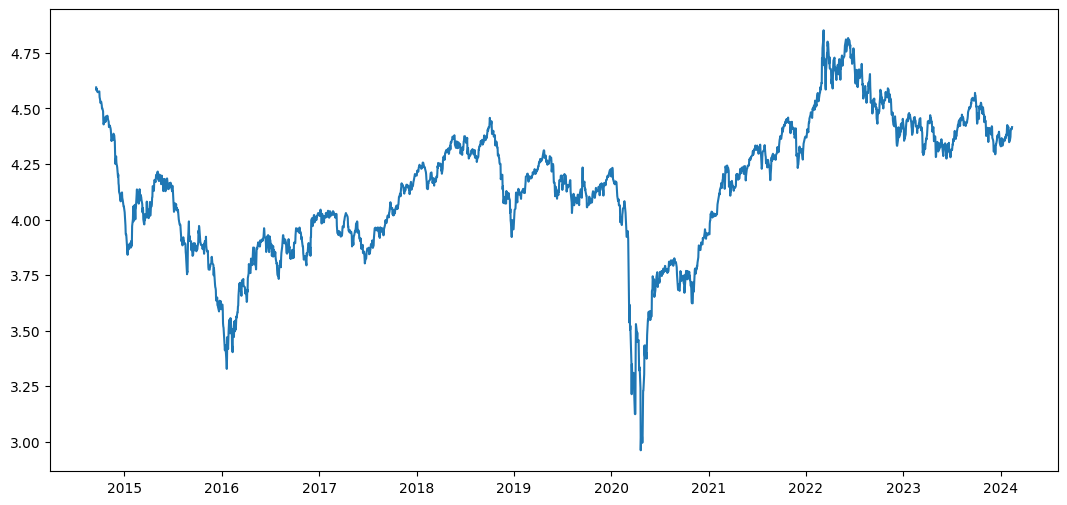


정성적 그래프 분석 :


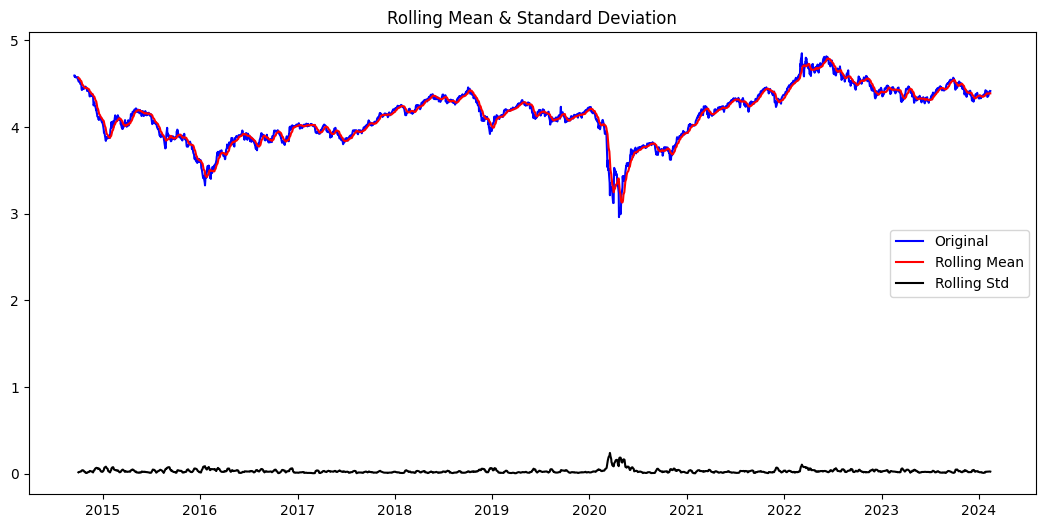


정량적 Augmented Dicky-Fuller Test :
Results of Dickey-Fuller Test:
Test Statistic                   -2.333343
p-value                           0.161440
#Lags Used                        0.000000
Number of Observations Used    2362.000000
Critical Value (1%)              -3.433122
Critical Value (5%)              -2.862764
Critical Value (10%)             -2.567422
dtype: float64

시계열 분해 (Time Series Decomposition) :


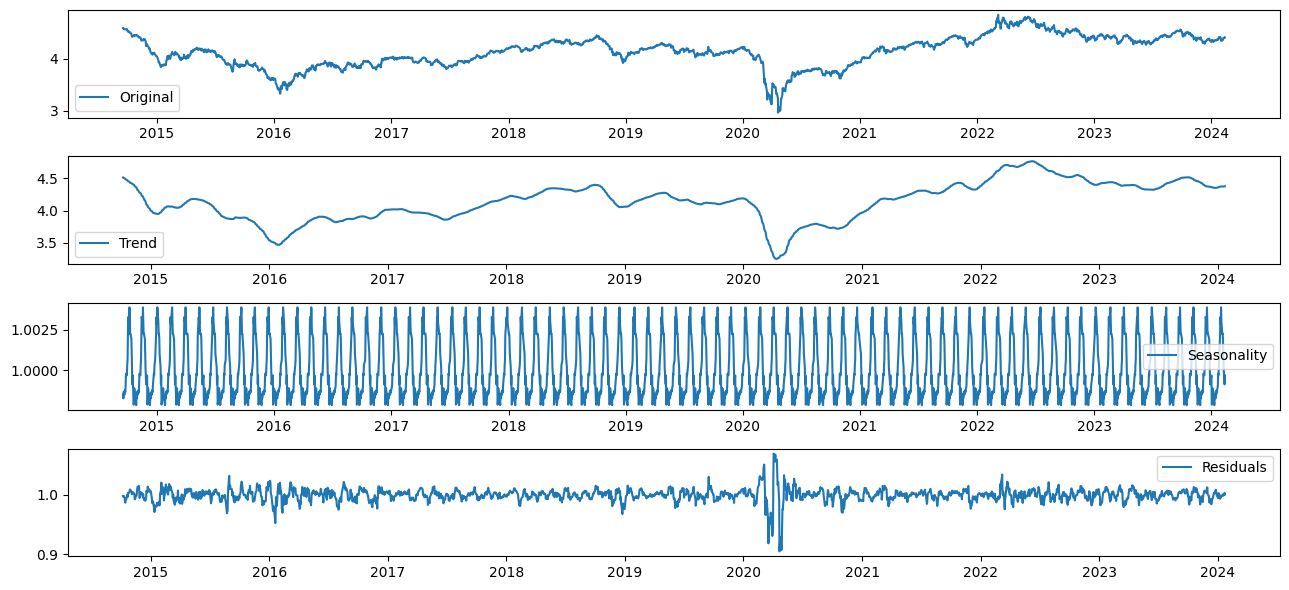

Results of Dickey-Fuller Test:
Test Statistic                -1.283870e+01
p-value                        5.667674e-24
#Lags Used                     2.300000e+01
Number of Observations Used    2.309000e+03
Critical Value (1%)           -3.433185e+00
Critical Value (5%)           -2.862793e+00
Critical Value (10%)          -2.567437e+00
dtype: float64

학습과 테스트 데이터셋 :


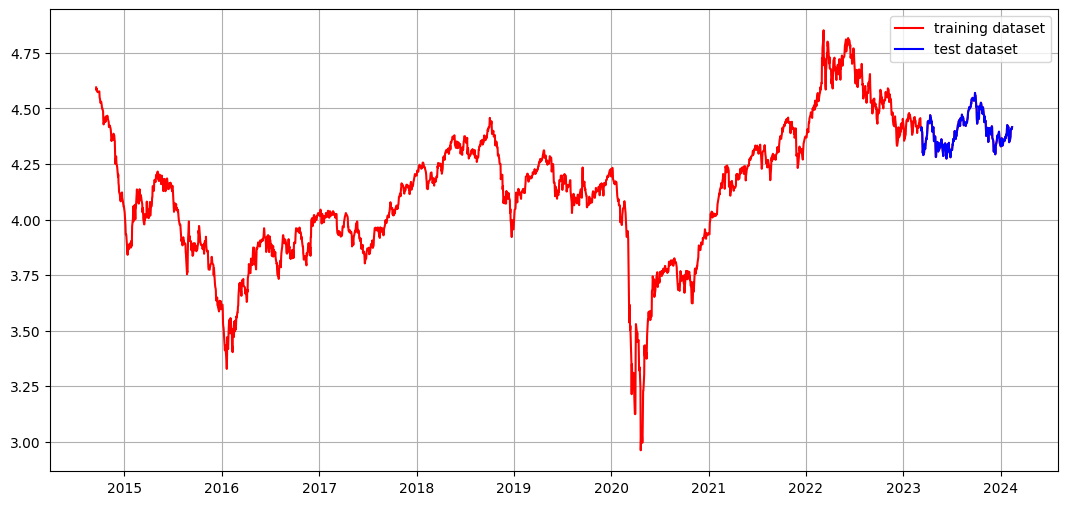


ACF : Autocorrelation 그래프 :


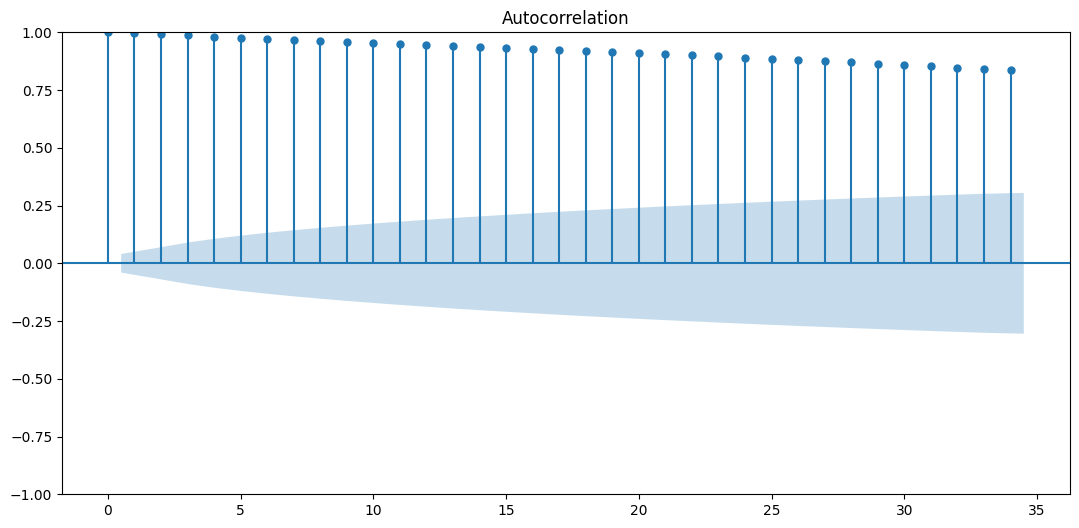


PACF : Partial Autocorrelation 그래프 :


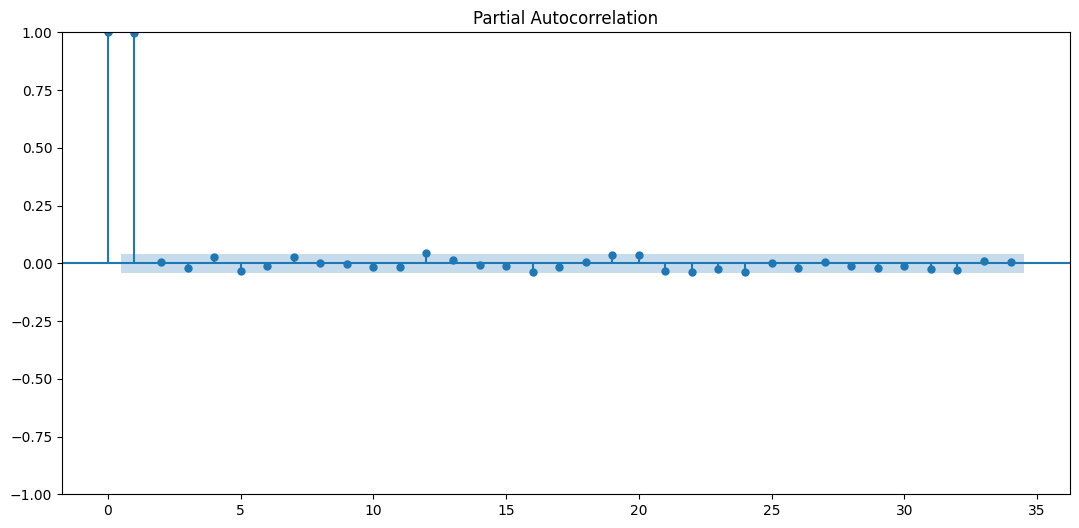


1차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                  -23.560619
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    2358.000000
Critical Value (1%)              -3.433126
Critical Value (5%)              -2.862767
Critical Value (10%)             -2.567423
dtype: float64

2차 차분 구하기 :
Results of Dickey-Fuller Test:
Test Statistic                -1.643764e+01
p-value                        2.444779e-29
#Lags Used                     2.700000e+01
Number of Observations Used    2.333000e+03
Critical Value (1%)           -3.433156e+00
Critical Value (5%)           -2.862780e+00
Critical Value (10%)          -2.567430e+00
dtype: float64


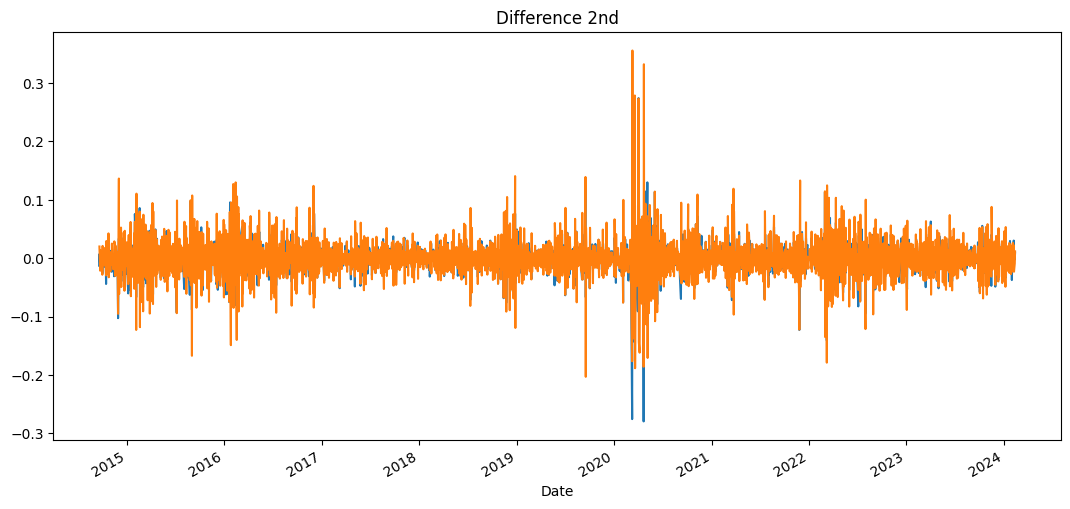

In [9]:
stock_id = 'BZ=F'
period = 30
train_data, test_data = stock_stationarity(stock_id, period)

In [27]:
# arima모델의 p,d,q의 숫자를 찾아주는 함수
from pmdarima.arima import auto_arima

arima_model = auto_arima(train_data, start_p=0, d=1, start_q=0,
                        max_p=3, max_d=3, max_q=3,
                        seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9299.042, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9297.100, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9297.098, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9301.021, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9295.099, Time=0.85 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.794 seconds


In [30]:
# ARIMA 모델의 오차율 계산
p, d, q = 1, 1, 2
stock_metrics(train_data, test_data, p, d, q)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA fitted model :

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2126
Model:                 ARIMA(1, 1, 2)   Log Likelihood                4652.436
Date:                Thu, 15 Feb 2024   AIC                          -9296.871
Time:                        12:33:09   BIC                          -9274.225
Sample:                             0   HQIC                         -9288.582
                               - 2126                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3595      0.447     -0.805      0.421      -1.235       0.516
ma.L1          0.3546      0.450      0.788      0.431      -0.527       1.236
ma.L2          0.0251      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


KeyError: 0